In [8]:
import os
import string
import numpy as np
import cv2
from pickle import dump, load
import matplotlib.pyplot as plt
%matplotlib inline

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Dense

In [4]:
curr_path = os.getcwd()
descriptions_file_dir = os.path.join(curr_path, "Descriptions/Flickr8k.token.txt")
train_images_dir = os.path.join(curr_path, "Descriptions/Flickr_8k.trainImages.txt")
test_images_dir = os.path.join(curr_path, "Descriptions/Flickr_8k.testImages.txt")
dev_images_dir = os.path.join(curr_path, "Descriptions/Flickr_8k.devImages.txt")
images_dir = os.path.join(curr_path, "Flicker8k_Dataset")

save_dir = os.path.join(curr_path, "preprocessed_data")
features_dict_path = os.path.join(save_dir, 'features_dict')
descriptions_dict_path = os.path.join(save_dir, 'descriptions_dict')
descriptions_text_path = os.path.join(save_dir, 'descriptions_text')

print("Image Directory: {}\nDescriptions Directory: {}".format(images_dir, descriptions_file_dir))

Image Directory: D:\Datasets\Flickr-8k\Flicker8k_Dataset
Descriptions Directory: D:\Datasets\Flickr-8k\Descriptions/Flickr8k.token.txt


In [12]:
def load_document(doc_path):
    file = open(doc_path, 'r')
    all_text = file.read()
    file.close()
    return all_text

def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    return img

table = str.maketrans('', '', string.punctuation)
def clean_desc(img_desc_list):
    clean_text_list = []
    for word in img_desc_list:
        if word.isalpha():
            word = word.lower()
            word.translate(table)
            if len(word) < 1:
                continue
            clean_text_list.append(word)
    return " ".join(clean_text_list)

def map_descriptions(all_text):
    mapping_dict = dict()
    mapping_text = ''
    for line in all_text.split('\n'):
        words_list = line.split()
        if len(words_list) < 2:
            continue
        img_id, img_desc_list = words_list[0].split('.')[0], words_list[1:]
        img_desc = clean_desc(img_desc_list)
        img_desc = 'start_seq ' + img_desc + ' end_seq'
        if not img_id in mapping_dict:
            mapping_dict[img_id] = list()
        mapping_dict[img_id].append(img_desc)
        mapping_text = mapping_text + img_id + ' ' + img_desc + '\n'
    return mapping_dict, mapping_text

def vocabolary(mapping_dict):
    vocab = set()
    for key in mapping_dict.keys():
        [vocab.update(d.split()) for d in mapping_dict[key]]
    return vocab

def extract_features():
    model = VGG16()
    model.layers.pop()
    output_layer = Dense(units=1024)(model.output)
    model = Model(inputs = model.inputs, outputs=output_layer)
    features_dict = dict()
    for i, img_name in enumerate(os.listdir(images_dir)):
        curr_img_path = os.path.join(images_dir, img_name)
        curr_img = preprocess_input(load_and_preprocess_image(curr_img_path))
        feature = model.predict(curr_img, verbose=0)
        image_id = img_name.split('.')[0]
        features_dict[image_id] = feature
        if (i+1) % 1000 == 0:
            print(i+1, " done")
    return features_dict

def save_data(file_path, data):
    dump(data, open(file_path, 'wb'))

def load_data(file_path):
    return load(open(file_path, 'rb'))

def plot_example_images(descriptions_dict, size=8):
    keys = list(descriptions_dict.keys())
    indexes = np.random.randint(0, len(keys), size = size)
    fig, axes = plt.subplots(size, 1, figsize=(5*size, 5*size))
    for i, ax in enumerate(axes.flat):
        img_name = keys[indexes[i]]
        img_desc = "\n".join([" ".join(desc.split()[1:-1]) for desc in descriptions_dict[img_name]])
        img = load_and_preprocess_image(os.path.join(images_dir, str(keys[indexes[i]]) + ".jpg"))[0]
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.text(ax.get_xbound()[1] + 10, int(np.average(ax.get_ybound()))+10, img_desc, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])

In [6]:
doc = load_document(descriptions_file_dir)
descriptions_dict, descriptions_text = map_descriptions(doc)

In [7]:
list(descriptions_dict.items())[8]

('1015118661_980735411b',
 ['start_seq a boy smiles in front of a stony wall in a city end_seq',
  'start_seq a little boy is standing on the street while a man in overalls is working on a stone wall end_seq',
  'start_seq a young boy runs aross the street end_seq',
  'start_seq a young child is walking on a stone paved street with a metal pole and a man behind him end_seq',
  'start_seq smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him end_seq'])

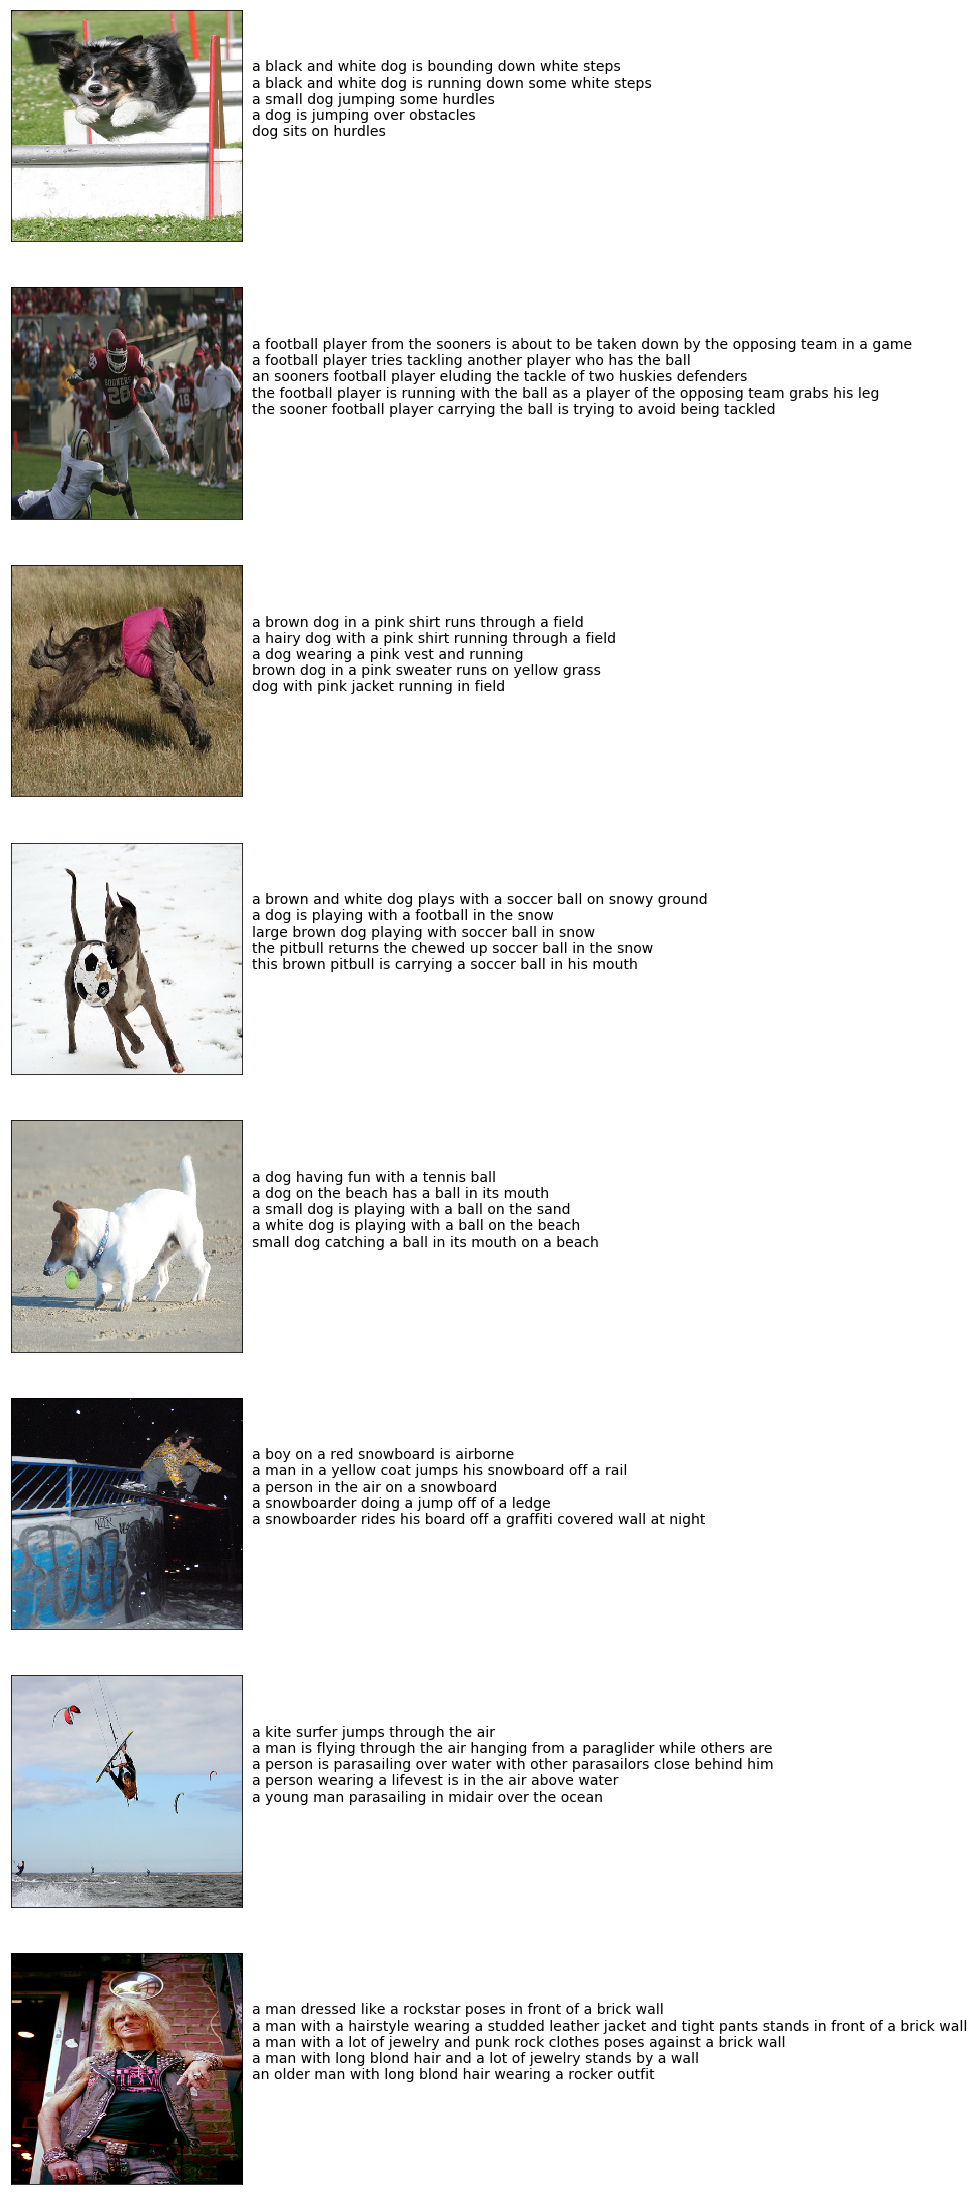

In [10]:
plot_example_images(descriptions_dict, size = 8)

In [13]:
features_dict = extract_features()

1000  done
2000  done
3000  done
4000  done
5000  done
6000  done
7000  done
8000  done


In [14]:
save_data(descriptions_dict_path, descriptions_dict)
save_data(descriptions_text_path, descriptions_text)
save_data(features_dict_path, features_dict)

In [183]:
train_tokenizer, vocab_size, max_length = create_tokenizer(train_image_annotations)
# test_tokenizer, _, _ = create_tokenizer(test_img_desc)
# X1, X2, Y = create_sequences(tokenizer, train_img_desc, train_img_features, vocab_size, max_length)

In [178]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

In [179]:
def model(max_length, vocab_size):
    input1 = Input(shape=(1024,))
    x1 = Dropout(0.25)(input1)
    x1 = Dense(units=256, activation='relu')(x1)
    
    input2 = Input(shape=(max_length,))
    x2 = Embedding(vocab_size, 256, mask_zero=True)(input2)
    x2 = Dropout(0.5)(x2)
    x2 = LSTM(256)(x2)
    
    d = add([x1, x2])
    d = Dense(256, activation='relu')(d)
    
    output = Dense(units=vocab_size, activation='softmax')(d)
    
    model = Model(inputs=[input1, input2], outputs=output)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
#     plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [184]:
model = model(max_length, vocab_size)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 36)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 36, 256)      1862656     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1024)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [188]:
def data_generator(tokenizer, img_desc, img_features, vocab_size, max_length):
    # loop for ever over images
    while 1:
        for key, desc_list in img_desc.items():
            # retrieve the photo feature
            feature = img_features[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, desc_list, feature, vocab_size, max_length)
            yield ([in_img, in_seq], out_word)

In [189]:
gen = data_generator(train_tokenizer, train_image_annotations, train_image_features, vocab_size, max_length)
i,o = next(data_generator)

TypeError: 'function' object is not an iterator

In [192]:
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
model.fit_generator(data_generator(train_tokenizer, train_image_annotations, train_image_features, vocab_size, max_length),\
                    epochs=10, verbose=1, callbacks=[checkpoint], steps_per_epoch=len(train_image_annotations),\
                    validation_data=data_generator(train_tokenizer, dev_image_annotations, dev_image_features, vocab_size, max_length),\
                   validation_steps=10\
                   )

Epoch 1/10
4290/6000 [====================>.........] - ETA: 3:01 - loss: 3.6693 - acc: 0.3856

KeyboardInterrupt: 

In [20]:
model.save('model.h5')